<a href="https://colab.research.google.com/github/pqrt12/BigData/blob/master/Challenge_Analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Java, Spark, Findspark, postgres, etc.

In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ChallengeAnalysis").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

## Extract



In [0]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
aws_s3_base_url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/"
#filename = "sample_us.tsv"
filename = "amazon_reviews_us_Wireless_v1_00.tsv.gz"
spark.sparkContext.addFile(aws_s3_base_url + filename)
raw_data_df = spark.read.csv(SparkFiles.get(filename), sep="\t", header=True, inferSchema=True)

In [4]:
# Show DataFrame
raw_data_df.show(3)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|        review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-------------------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...|2015-08-31 00:00:00|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516894650|Selfie Stick Fibl...| 

## Transform
### filtering

In [5]:
# transform, filtering:
#   dropna, keep essentail columns only
clean_data_df = raw_data_df.dropDuplicates(['review_id'])         \
                          .dropna().select(['star_rating', 'helpful_votes', 'total_votes', 'vine'])
clean_data_df.show(3)

+-----------+-------------+-----------+----+
|star_rating|helpful_votes|total_votes|vine|
+-----------+-------------+-----------+----+
|          4|            0|          0|   N|
|          1|            0|          2|   N|
|          5|            0|          2|   N|
+-----------+-------------+-----------+----+
only showing top 3 rows



In [0]:
# keep influential opinions only
select_df = clean_data_df.filter((clean_data_df['total_votes'] > 10) & (clean_data_df['helpful_votes'] > 3))
#select_df = clean_data_df

### pySpark Statistics

In [7]:
select_df.filter(select_df['vine'] == 'N').select(['star_rating', 'helpful_votes', 'total_votes']).describe().show()

+-------+------------------+-----------------+-----------------+
|summary|       star_rating|    helpful_votes|      total_votes|
+-------+------------------+-----------------+-----------------+
|  count|            142586|           142586|           142586|
|   mean|3.4538033186988906|32.16986941214425|37.32847544639726|
| stddev|1.6645966320197683|80.54649483818837| 85.1031104498575|
|    min|                 1|                4|               11|
|    max|                 5|             5854|             6063|
+-------+------------------+-----------------+-----------------+



In [8]:
select_df.filter(select_df['vine'] == 'Y').select(['star_rating', 'helpful_votes', 'total_votes']).describe().show()

+-------+------------------+------------------+------------------+
|summary|       star_rating|     helpful_votes|       total_votes|
+-------+------------------+------------------+------------------+
|  count|              1047|              1047|              1047|
|   mean| 3.884431709646609| 58.77077363896848| 64.68672397325692|
| stddev|1.1229469206867972|118.94566695775106|124.12508049349833|
|    min|                 1|                 4|                11|
|    max|                 5|              1735|              1795|
+-------+------------------+------------------+------------------+



### transform to pandas dataframe
pySpark is done

In [0]:
pdf = select_df.groupBy('star_rating', 'vine')                            \
          .agg({'helpful_votes':'avg', 'total_votes':'avg', '*':'count'}) \
          .toPandas()

### pandas dataframe transform

In [0]:
# import the pandas module  
import pandas as pd

In [11]:
pdf

,star_rating,vine,avg(total_votes),count(1),avg(helpful_votes)
0,5,N,39.104596,62440,35.434978
1,2,N,31.063428,10437,24.568267
2,3,N,38.915107,12451,33.308570
3,1,Y,33.518519,54,27.111111
4,2,Y,46.666667,69,38.971014
5,4,N,40.086880,21593,36.511601
6,5,Y,74.808000,375,68.970667
7,3,Y,57.739796,196,51.071429
8,1,N,33.828403,35665,25.651872
9,4,Y,66.082153,353,60.923513


In [12]:
col_renames = {'avg(total_votes)': 'avg_total_votes',
               'count(1)': 'count',
               'avg(helpful_votes)': 'avg_helpful_votes'
              }
pdf = pdf.rename(columns=col_renames)
pdf

,star_rating,vine,avg_total_votes,count,avg_helpful_votes
0,5,N,39.104596,62440,35.434978
1,2,N,31.063428,10437,24.568267
2,3,N,38.915107,12451,33.308570
3,1,Y,33.518519,54,27.111111
4,2,Y,46.666667,69,38.971014
5,4,N,40.086880,21593,36.511601
6,5,Y,74.808000,375,68.970667
7,3,Y,57.739796,196,51.071429
8,1,N,33.828403,35665,25.651872
9,4,Y,66.082153,353,60.923513


In [13]:
pdf.dtypes

star_rating           object
vine                  object
avg_total_votes      float64
count                  int64
avg_helpful_votes    float64
dtype: object

In [14]:
# vine rating normalize.
vine = pdf.loc[pdf['vine'] == 'Y']
t = vine.copy(deep=True)
vine['count'] = t['count'] / t['count'].sum()
vine

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,star_rating,vine,avg_total_votes,count,avg_helpful_votes
3,1,Y,33.518519,0.051576,27.111111
4,2,Y,46.666667,0.065903,38.971014
6,5,Y,74.808000,0.358166,68.970667
7,3,Y,57.739796,0.187202,51.071429
9,4,Y,66.082153,0.337154,60.923513


In [15]:
# non_vine rating normalize.
non_vine = pdf.loc[pdf['vine'] == 'N']
t = non_vine.copy(deep=True)
non_vine['count'] = t['count'] / t['count'].sum()
non_vine

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,star_rating,vine,avg_total_votes,count,avg_helpful_votes
0,5,N,39.104596,0.437911,35.434978
1,2,N,31.063428,0.073198,24.568267
2,3,N,38.915107,0.087323,33.308570
5,4,N,40.086880,0.151438,36.511601
8,1,N,33.828403,0.250130,25.651872


In [17]:
final_pdf.dtypes

star_rating    int64
dtype: object

In [27]:
vine.dtypes

star_rating            int64
vine                  object
avg_total_votes      float64
count                float64
avg_helpful_votes    float64
dtype: object

In [0]:
vine = vine.astype({"star_rating": int})
non_vine = non_vine.astype({"star_rating": int})

In [29]:
# final pandas dataframe
data = {'star_rating':[1, 2, 3, 4, 5]}
final_pdf = pd.DataFrame(data)
final_pdf = pd.merge(final_pdf, vine, on='star_rating', how='left')
final_pdf = pd.merge(final_pdf, non_vine, on='star_rating', how='left')
final_pdf = final_pdf.fillna(0)
col_renames = {'count_x': 'vine_count',
               'count_y': 'non_vine_count',
               'avg_helpful_votes_x': 'vine_avg_helpful_votes',
               'avg_helpful_votes_y': 'non_vine_avg_helpful_votes',
               'avg_total_votes_x': 'vine_avg_total_votes',
               'avg_total_votes_y': 'non_vine_avg_total_votes' 
               }
final_pdf = final_pdf.rename(columns=col_renames)
final_pdf = final_pdf[['star_rating',
                      'vine_count', 'vine_avg_helpful_votes', 'vine_avg_total_votes',
                      'non_vine_count', 'non_vine_avg_helpful_votes', 'non_vine_avg_total_votes']]
final_pdf

,star_rating,vine_count,vine_avg_helpful_votes,vine_avg_total_votes,non_vine_count,non_vine_avg_helpful_votes,non_vine_avg_total_votes
0,1,0.051576,27.111111,33.518519,0.250130,25.651872,33.828403
1,2,0.065903,38.971014,46.666667,0.073198,24.568267,31.063428
2,3,0.187202,51.071429,57.739796,0.087323,33.308570,38.915107
3,4,0.337154,60.923513,66.082153,0.151438,36.511601,40.086880
4,5,0.358166,68.970667,74.808000,0.437911,35.434978,39.104596


## Analysis
### pandas df plot

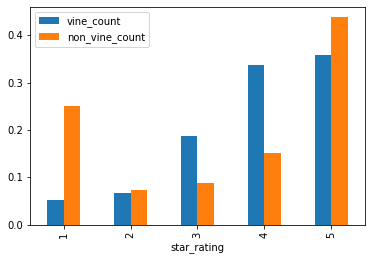

In [30]:
# vine / non_vine normalized "star_rating" distribution
final_pdf.plot(x="star_rating", y=["vine_count", "non_vine_count"], kind="bar")

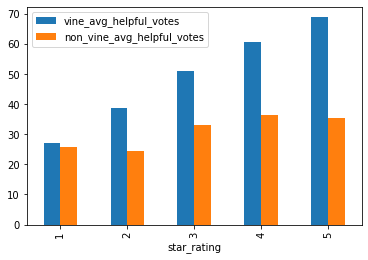

In [31]:
final_pdf.plot(x="star_rating", y=["vine_avg_helpful_votes", "non_vine_avg_helpful_votes"], kind="bar")

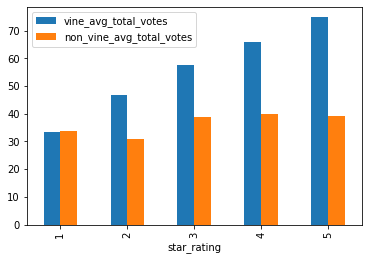

In [32]:
final_pdf.plot(x="star_rating", y=["vine_avg_total_votes", "non_vine_avg_total_votes"], kind="bar")